In [1]:
# GPU scaling lidDrivenCavity
# comparison OF + DIC vs GKO and var. preconditioner
import matplotlib.pyplot as plt
import numpy as np
from import_benchmark_data import import_results
from helpers import idx_query, idx_keep_only, compute_speedup

plt.rcParams.update({'font.size': 18})

No Salvia installation found
Owls Version: 0.10.0-26-g31283c0
Warning no matplotlib support


In [2]:
def line_plot(df, x, columns, facet, properties, 
              fig, axes, kind="line", x_label=None, 
              facet_is_legend=False):
    lines = list(set(df.index.get_level_values(facet)))
    lines.sort()
    default_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
    for i, q in enumerate(columns):
        for j,line in enumerate(lines):
            sel = df[df.index.get_level_values(facet) == line]
            sel = idx_keep_only(sel,  keep=[x])
            ax = axes[i]
            legends = properties.get("legends")
            legend = line  if facet_is_legend else False
            f = sel.sort_index().plot(
                legend=True,
                label=legend,
                lw=3,
                ms=10,
                kind=kind,
                ax=ax,
                linestyle=properties.get("linestyle", lambda x: "-")(line),
                marker=properties["marker"](line),
                color=properties.get("color", lambda x: default_colors[j])(line),
            )
            if x_label:
                ax.set_xlabel(x_label[i])
            if legends:
                plt.legend(legends)

In [6]:
revision = "89dc98cf"
case = "simple_host_buffer"
path = "../../results/{}/lidDrivenCavity/".format(revision)

In [7]:
def calc_nodes(df, sel, masks):
    df["nodes"] = df.index.get_level_values('mpi_ranks')
    for sel_value, value in masks:
        mask = df.index.get_level_values(sel) == sel_value
        df.loc[mask,"nodes"] = df.loc[mask, "nodes"]/value
    df = df.set_index("nodes", append=True)
    return df

../../results/89dc98cf/lidDrivenCavity/simple_host_buffer/Logs
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte


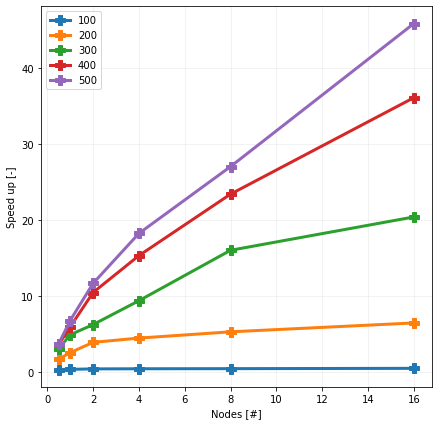

In [22]:
df = import_results(
    path=path,
    case=case,        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka"
    },
    transform_resolution=False
    )["raw"]

columns = ["linear_solve_p"] 

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(7 * len(columns), 7),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Speed up [-]")


axes = [axes]

df = idx_query(df, 
        [
            ("solver_p", "CG"),
            ("node", "horeka", True),
        ])


df = df.drop(["log_id", "timestamp" , "case"] ,axis=1)

df = calc_nodes(df, "executor_p", [("DefaultOF", 64),("CUDA",4)])


of_data = compute_speedup(df,
        [("nodes", 1),
         ("executor_p", "DefaultOF")
        ],
        drop_indices=["node", "mpiRank_of", "processes", "mpiRank_gko", "omp_threads", "mpi_ranks"],
        )

of_data = idx_query(of_data, [
        ("executor_p", "CUDA"),    
    ]).sort_index()

                    
line_plot(of_data["linear_solve_p"], 
    x="nodes", 
    columns=columns, 
    facet="resolution",
    #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
    fig=fig,
    axes=axes,
    facet_is_legend=True,
    properties={
    #"legends": ["8M", "17M", "34M"],
    "marker": lambda x: "P",
    "title": lambda x: ["Linear Solve P"][x]
})

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")
        #ax.set_yscale('log')
        #ax.set_xscale('log')

plt.savefig(path + case + "/linear_solve_multi_gpu_vs_single_node.png", bbox_inches='tight')

<AxesSubplot:xlabel='nodes'>

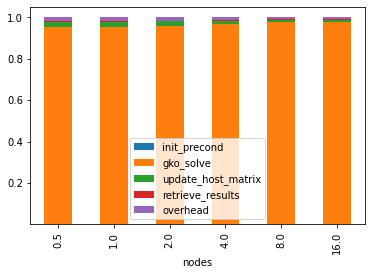

In [27]:
cuda = idx_query(df, 
    [("executor_p", "CUDA"),
     ("resolution", 500)]           
                )
cuda = cuda[['init_precond', 'gko_solve', 'update_host_matrix', "retrieve_results"]].div(cuda["linear_solve_p"], axis=0)
cuda = idx_keep_only(cuda, ["nodes"])

cuda["overhead"] = (1 
        - cuda['init_precond'] 
        - cuda['gko_solve']
        - cuda['update_host_matrix']
        - cuda['retrieve_results']                        
                                )

cuda.sort_index().plot.bar(stacked=True)

<AxesSubplot:xlabel='resolution'>

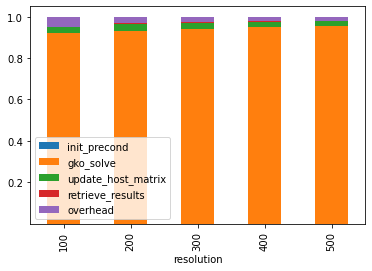

In [28]:
cuda = idx_query(df, 
    [("executor_p", "CUDA"),
     ("nodes", 1)]           
                )
cuda = cuda[['init_precond', 'gko_solve', 'update_host_matrix', "retrieve_results"]].div(cuda["linear_solve_p"], axis=0)
cuda = idx_keep_only(cuda, ["resolution"])

cuda["overhead"] = (1 
        - cuda['init_precond'] 
        - cuda['gko_solve']
        - cuda['update_host_matrix']
        - cuda['retrieve_results']                        
                                )

cuda.sort_index().plot.bar(stacked=True)

In [3]:
fig, axes = plt.subplots(1,
                        len(columns),
                        figsize=(7 * len(columns), 7),
                        sharex=False,
                        sharey=False,
                        gridspec_kw={'wspace': 0.5},
                        subplot_kw={'frameon': True})
axes.set_ylabel("Speed up [-]")
axes = [axes]


for revision, marker, line, cores, case in [
    ("89dc98cf", "P", "-", 64, "simple_host_buffer" ),
    ("f66ef73d","P","-.", 64, "simple")]:
        
    path = "../../results/{}/lidDrivenCavity/".format(revision)
    df = import_results(
            path=path,
            case=case,        
            short_hostname_map={
                "nla": "nla",
                "hkn": "horeka"
            },
            transform_resolution=False
            )["raw"]

    columns = ["linear_solve_p"] 


    df = idx_query(df, 
            [
                ("solver_p", "CG"),
                ("node", "horeka", True),
            ])


    df = df.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)

    df = calc_nodes(df, "executor_p", [("DefaultOF", 64),("CUDA",4)])

    of_data = compute_speedup(df,
            [("nodes", 1),
             ("executor_p", "DefaultOF")
            ],
            drop_indices=["node", "mpiRank_of", "processes", "mpiRank_gko", "omp_threads", "mpi_ranks"],
            )

    of_data = idx_query(of_data, [
            ("executor_p", "CUDA"),    
        ]).sort_index()


    line_plot(of_data["linear_solve_p"], 
        x="nodes", 
        columns=columns, 
        facet="resolution",
        #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
        fig=fig,
        axes=axes,
        facet_is_legend=True,
        properties={
        #"legends": ["8M", "17M", "34M"],
        "linestyle": lambda x: line,
        "marker": lambda x: marker,
        "title": lambda x: ["Linear Solve P"][x]
    })

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")
        #ax.set_yscale('log')
        #ax.set_xscale('log')

plt.savefig(path + case + "/linear_solve_multi_gpu_vs_single_node.png", bbox_inches='tight')

NameError: name 'columns' is not defined

../../results/89dc98cf/lidDrivenCavity/simple_host_buffer/Logs
'utf-8' codec can't decode byte 0x89 in position 0: invalid start byte


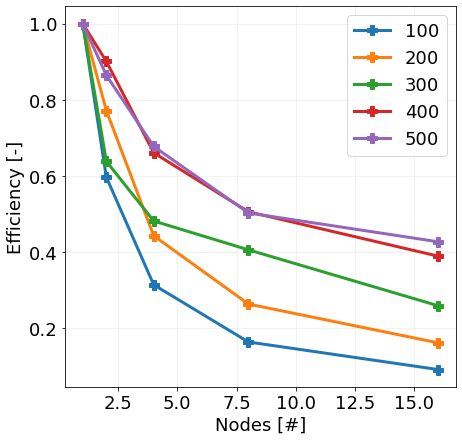

In [40]:

df = import_results(
    path=path,
    case=case,        
    short_hostname_map={
        "nla": "nla",
        "hkn": "horeka"
    },
    transform_resolution=False
    )["raw"]


columns = ["linear_solve_p"] #, "number_iterations_p" ]

fig, axes = plt.subplots(1,
                    len(columns),
                    figsize=(7 * len(columns), 7),
                    sharex=False,
                    sharey=False,
                    gridspec_kw={'wspace': 0.5},
                    subplot_kw={'frameon': True})
axes.set_ylabel("Efficiency [-]")


axes = [axes]

df = idx_query(df, 
        [
            ("solver_p", "CG"),
            ("node", "horeka", True),
           # ("resolution", 500, False),
           # ("resolution", b)
        ])

df = df.drop(["init_precond", "update_host_matrix", "retrieve_results", "log_id", "timestamp"] ,axis=1)
df["nodes"] = df.index.get_level_values('mpi_ranks')
df["gpus"] = df.index.get_level_values("mpiRank_gko")

df = calc_nodes(df, "executor_p", [("DefaultOF", 64),("CUDA",4)])

of_data = compute_speedup(df,
        [("nodes", 1),
         ("executor_p", "CUDA")
        ],
        drop_indices=["node", "mpiRank_of", "processes", "mpiRank_gko", "omp_threads", "mpi_ranks"],
        )

of_data["efficiency_linear_solve_p_per_iter"] = of_data["linear_solve_p_per_iter"]*of_data["gpus"]

of_data = idx_query(of_data, [
        ("executor_p", "CUDA"),
        ("nodes", 0.5, False),    
    ]).sort_index()

              
line_plot(of_data["efficiency_linear_solve_p_per_iter"], 
    x="nodes", 
    columns=columns, 
    facet="resolution",
    #fn='../results/cur/lidDrivenCavity/gko_vs_of_linear_solve_vs_precond.png',
    fig=fig,
    axes=axes,
    facet_is_legend=True,
    properties={
    #"legends": ["8M", "17M", "34M"],
    "marker": lambda x: "P",
    "title": lambda x: ["Linear Solve P"][x]
})

for ax in axes:
        ax.grid(True, axis='x', which="both", alpha=0.2)
        ax.grid(True, axis='y', which="both", alpha=0.2)
        ax.grid(True, axis="y", which="minor", alpha=0.2)
        ax.set_xlabel("Nodes [#]")
        
plt.savefig(path + case + "/efficiency_solve_p_per_iter_multi_gpu_vs_single_node_CUDA.png", bbox_inches='tight')